In [2]:
#Installing necessary libraries

# Libraries
!pip install pyspellchecker
!pip install scattertext
!pip install nltk
!pip install -U kaleido
!pip install wordcloud

In [3]:
#Importing necessary libraries

# Import Data Preprocessing and Wrangling libraries
import re
from tqdm.notebook import tqdm
import pandas as pd 
import numpy as np
from datetime import datetime
import dateutil.parser

# Import NLP Libraries
import nltk
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Import Visualization Libraries
import plotly.offline as pyo 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns 
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random 

# Downloading periphrals
nltk.download('vader_lexicon')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\waghm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\waghm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#Initialization

import os
directory = 'C:/Users/waghm/Downloads/WEB DATASET'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
df_list = []
for csv in csv_files:
    df = pd.read_csv(os.path.join(directory, csv))
    df_list.append(df)
    

In [12]:
# Intializate our tools 
sns.set_style('darkgrid')

# For sentiment analysis 
sia = SIA() 

# To identify misspelled words
spell = SpellChecker() 

# To display plotly graphs 
pyo.init_notebook_mode() 

# Storing csv dataset into a datframe
df = pd.concat(df_list)

In [13]:
#Data Preprocessing

df.head()

tweet_id              tweet_created tweet_extracted  \
0  1.640000e+18  2023-04-03 03:59:28+00:00         06:52.5   
1  1.640000e+18  2023-04-03 15:59:59+00:00         07:04.7   
2  1.640000e+18  2023-04-03 01:59:25+00:00         06:50.6   
3  1.640000e+18  2023-04-03 11:59:28+00:00         07:00.4   
4  1.640000e+18  2023-04-03 12:59:26+00:00         07:01.4   

                                                text       user_id  \
0  rt  chatgpt plugins are the fastest way to get...  2.383246e+09   
1  get an intelligent chatbot for your website in...  1.633040e+18   
2  hey guys zenithswap has launched at just  5500...  1.311400e+18   
3  rt  now join sinso datalandchatgpt airdrop 323...  4.621427e+08   
4  the plagiarism detector will introduce its ai ...  8.960940e+17   

        user_location               user_created  user_followers_count  \
0               India  2014-03-11 06:04:10+00:00                 269.0   
1      United Kingdom  2023-03-07 09:43:36+00:00                 264.0   
2         Chicago, IL  2020-09-30 20:32:00+00:00                 447.0   
3     Zambia mufulira  2012-01-12 16:25:12+00:00                2286.0   
4  New Hampshire, USA  2017-08-11 19:41:50+00:00                4444.0   

   user_following_count  user_tweet_count user_verified  retweet_count  \
0                4141.0            3816.0         False          628.0   
1                  24.0             198.0         False            0.0   
2                 419.0           12949.0         False            0.0   
3                 982.0           20438.0         False          270.0   
4                1924.0            3320.0          True            7.0   

   like_count  reply_count  impression_count  
0         0.0          0.0               0.0  
1         0.0          0.0              58.0  
2         0.0          0.0               0.0  
3         0.0          0.0               0.0  
4        22.0          1.0            5769.0

In [14]:
data = df.copy()
data['original_tweet'] = df['text']
data['datetime'] = data['tweet_created']
data['datetime'] = data.datetime.apply(lambda x: dateutil.parser.parse(x))
rt_mask = data.text.apply(lambda x: "RT @" in x)

# standard tweet preprocessing 
data.text = data.text.str.lower()
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# convert the 'date' column to datetime format and remove the timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)


# Viewing the preprocessed data
data.head()

tweet_id              tweet_created tweet_extracted  \
0  1.640000e+18  2023-04-03 03:59:28+00:00         06:52.5   
1  1.640000e+18  2023-04-03 15:59:59+00:00         07:04.7   
2  1.640000e+18  2023-04-03 01:59:25+00:00         06:50.6   
3  1.640000e+18  2023-04-03 11:59:28+00:00         07:00.4   
4  1.640000e+18  2023-04-03 12:59:26+00:00         07:01.4   

                                                text       user_id  \
0  rt chatgpt plugins are the fastest way to get ...  2.383246e+09   
1  get an intelligent chatbot for your website in...  1.633040e+18   
2  hey guys zenithswap has launched at just 55000...  1.311400e+18   
3  rt now join sinso datalandchatgpt airdrop 3234...  4.621427e+08   
4  the plagiarism detector will introduce its ai ...  8.960940e+17   

        user_location               user_created  user_followers_count  \
0               India  2014-03-11 06:04:10+00:00                 269.0   
1      United Kingdom  2023-03-07 09:43:36+00:00                 264.0   
2         Chicago, IL  2020-09-30 20:32:00+00:00                 447.0   
3     Zambia mufulira  2012-01-12 16:25:12+00:00                2286.0   
4  New Hampshire, USA  2017-08-11 19:41:50+00:00                4444.0   

   user_following_count  user_tweet_count user_verified  retweet_count  \
0                4141.0            3816.0         False          628.0   
1                  24.0             198.0         False            0.0   
2                 419.0           12949.0         False            0.0   
3                 982.0           20438.0         False          270.0   
4                1924.0            3320.0          True            7.0   

   like_count  reply_count  impression_count  \
0         0.0          0.0               0.0   
1         0.0          0.0              58.0   
2         0.0          0.0               0.0   
3         0.0          0.0               0.0   
4        22.0          1.0            5769.0   

                                      original_tweet            datetime  
0  rt  chatgpt plugins are the fastest way to get... 2023-04-03 03:59:28  
1  get an intelligent chatbot for your website in... 2023-04-03 15:59:59  
2  hey guys zenithswap has launched at just  5500... 2023-04-03 01:59:25  
3  rt  now join sinso datalandchatgpt airdrop 323... 2023-04-03 11:59:28  
4  the plagiarism detector will introduce its ai ... 2023-04-03 12:59:26

In [15]:
#Feature Extraction

def label_sentiment(x:float):
    if x < -0.05 : return 'negative'
    if x > 0.35 : return 'positive'
    return 'neutral'

# Feature Extraction
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))
data['errors'] = data.words.apply(spell.unknown)
data['errors_count'] = data.errors.apply(len)
data['words_count'] = data.words.apply(len)
data['sentence_length'] = data.text.apply(len)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data['date'] = data.datetime.apply(lambda x: x.date())
data['month'] = data.datetime.apply(lambda x: x.month)
data['year'] = data.datetime.apply(lambda x: x.year)

# Extract Sentiment Values for each tweet 
data['sentiment'] = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
data['overall_sentiment'] = data['sentiment'].apply(label_sentiment);

  0%|          | 0/20114 [00:00<?, ?it/s]

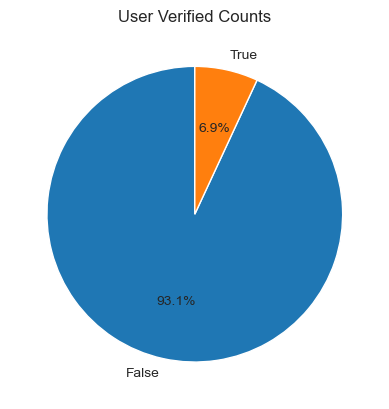

In [26]:
import matplotlib.pyplot as plt

# Get the value counts for user_verified
value_counts = data['user_verified'].value_counts()

# Create a pie chart
labels = value_counts.index
values = value_counts.values

plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('User Verified Counts')

# Display the chart
plt.show()

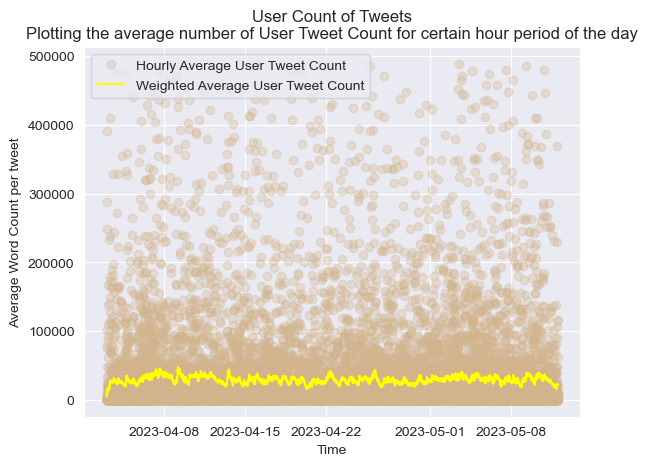

In [19]:
import matplotlib.pyplot as plt
import numpy as np

title = "User Count of Tweets\nPlotting the average number of User Tweet Count for certain hour period of the day"

beta = 0.99  # higher value -> smoother curve

length = data.groupby('datetime')['user_tweet_count'].mean()
length_std = length.std()
length = length[length < 3 * length_std]

def get_weighted(data, beta):
    weighted = np.zeros_like(data)
    weighted[0] = data[0]
    for i in range(1, len(data)):
        weighted[i] = beta * weighted[i-1] + (1 - beta) * data[i]
    return weighted

weighted_length = get_weighted(length.values, beta)
weighted_length = pd.Series(weighted_length, index=length.index)

plt.plot(length.index, length.values, 'o', color='tan', alpha=0.3, label="Hourly Average User Tweet Count")
plt.plot(weighted_length.index, weighted_length.values, color='yellow', label="Weighted Average User Tweet Count")

plt.title(title)
plt.xlabel("Time")
plt.ylabel("Average Word Count per tweet")
plt.legend()
plt.grid(True)
plt.show()



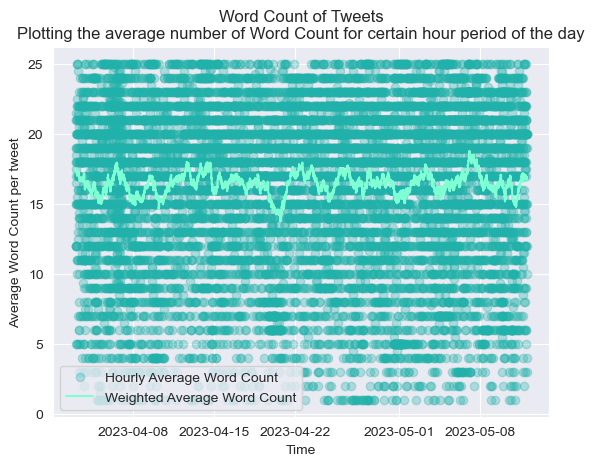

In [20]:
import matplotlib.pyplot as plt

title = "Word Count of Tweets\nPlotting the average number of Word Count for certain hour period of the day"

beta = 0.99  # higher value -> smoother curve

length = data.groupby('datetime')['words_count'].mean()
length_std = length.std()
length = length[length < 3 * length_std]

def get_weighted(data, beta):
    weighted = [data[0]]
    for i in range(1, len(data)):
        weighted.append(beta * weighted[i-1] + (1 - beta) * data[i])
    return weighted

weighted_length = get_weighted(length.values, beta)

plt.plot(length.index, length.values, 'o', color='lightseagreen', alpha=0.3, label="Hourly Average Word Count")
plt.plot(length.index, weighted_length, color='aquamarine', label="Weighted Average Word Count")

plt.title(title)
plt.xlabel("Time")
plt.ylabel("Average Word Count per tweet")
plt.legend()
plt.grid(True)
plt.show()


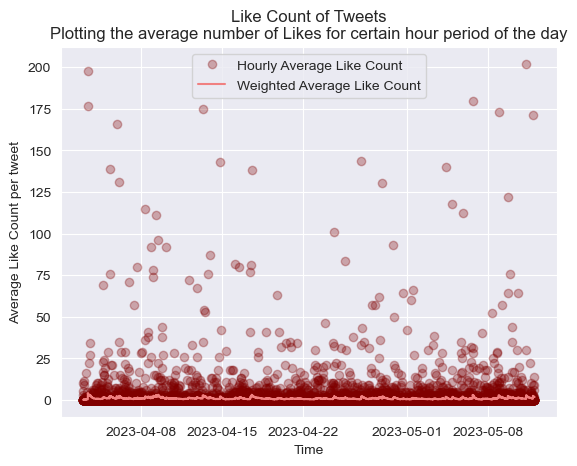

In [21]:
import matplotlib.pyplot as plt

title = "Like Count of Tweets\nPlotting the average number of Likes for certain hour period of the day"

beta = 0.99  # higher value -> smoother curve

length = data.groupby('datetime')['like_count'].mean()
length_std = length.std()
length = length[length < 3 * length_std]

def get_weighted(data, beta):
    weighted = [data[0]]
    for i in range(1, len(data)):
        weighted.append(beta * weighted[i-1] + (1 - beta) * data[i])
    return weighted

weighted_length = get_weighted(length.values, beta)

plt.plot(length.index, length.values, 'o', color='maroon', alpha=0.3, label="Hourly Average Like Count")
plt.plot(length.index, weighted_length, color='lightcoral', label="Weighted Average Like Count")

plt.title(title)
plt.xlabel("Time")
plt.ylabel("Average Like Count per tweet")
plt.legend()
plt.grid(True)
plt.show()



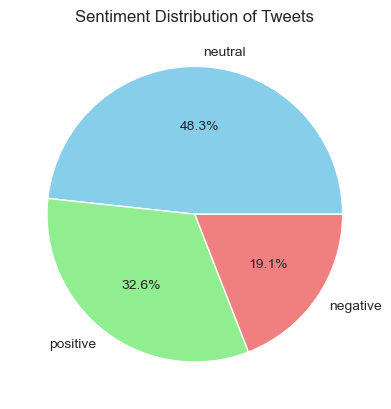

In [23]:
import matplotlib.pyplot as plt

# Count the number of tweets in each sentiment category
sentiment_counts = data['overall_sentiment'].value_counts()

# Create a pie chart
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])

# Customize the plot
plt.title('Sentiment Distribution of Tweets')

# Show the plot
plt.show()




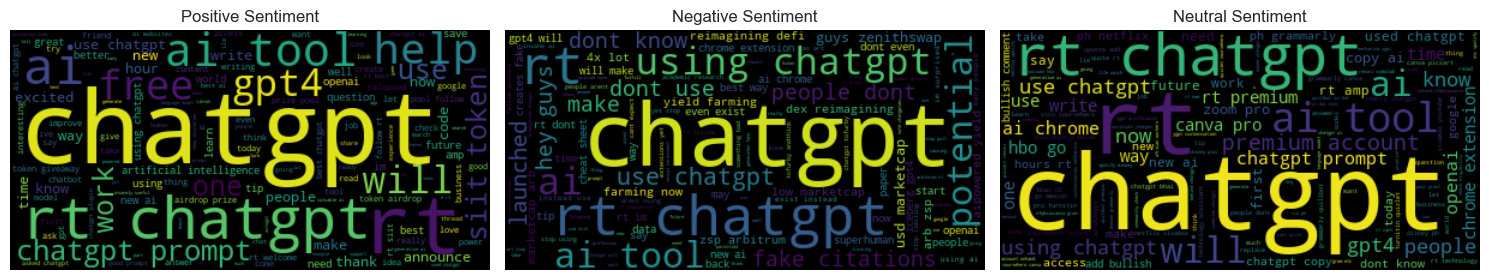

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the tweets for each sentiment category
positive_tweets = data[data['overall_sentiment'] == 'positive']['text']
negative_tweets = data[data['overall_sentiment'] == 'negative']['text']
neutral_tweets = data[data['overall_sentiment'] == 'neutral']['text']

# Generate word clouds for each sentiment category
wordcloud_positive = WordCloud().generate(' '.join(positive_tweets))
wordcloud_negative = WordCloud().generate(' '.join(negative_tweets))
wordcloud_neutral = WordCloud().generate(' '.join(neutral_tweets))

# Create subplots for each word cloud
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the word clouds
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Sentiment')
axes[0].axis('off')

axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Sentiment')
axes[1].axis('off')

axes[2].imshow(wordcloud_neutral, interpolation='bilinear')
axes[2].set_title('Neutral Sentiment')
axes[2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the word clouds
plt.show()
